# 1. Process Nodule Dataset

## Summary

* Load scans and convert to pixels
* Process image by normalizing, then removing everything outside of the lung tissue
* Generate nodule masks by loading nodule coordiates from list3.2 csv file and using the cellmagicwand tool over that coordinate

In [15]:
# File paths
metadatapath="LIDC/test/LIDC-IDRI_MetaData.csv"
list32path="LIDC/test/list3.2.csv"
DOIfolderpath='LIDC/LIDC-IDRI/'
datafolder='processeddata'


import cell_magic_wand as cmw
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

from skimage import measure, morphology
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.draw import circle
#Load metadata
meta=pd.read_csv(metadatapath)
meta=meta.drop(meta[meta['Modality']!='CT'].index)
meta=meta.reset_index()

#Get folder names of CT data for each patient
patients=[DOIfolderpath+meta['Patient Id'][i] for i in range(len(meta))]


datfolder=[]
for i in range(0,len(meta)-1):
    for path in os.listdir(patients[i]):
        print(patients[i] + "/" + path + "/" + os.listdir(patients[i] + "/" + path)[0])
        datfolder.append(patients[i] + "/" + path + "/" + os.listdir(patients[i] + "/" + path)[0])
        # Make thia work first
#         if os.path.exists(patients[i]+'/'+path+'/'):
#             datfolder.append(patients[i]+'/'+path+'/'+meta['Series UID'][i])
patients=datfolder

#Load nodules locations
nodulelocations=pd.read_csv(list32path)
print(patients)




LIDC/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192
LIDC/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-35511/3000923-62357
LIDC/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-26851/3000972-22902
LIDC/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522-04919
LIDC/LIDC-IDRI/LIDC-IDRI-0003/01-01-2000-59141/3000978-59882
LIDC/LIDC-IDRI/LIDC-IDRI-0003/01-01-2000-94866/3000611-03264
LIDC/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-88534/3000897-82201
LIDC/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-91780/3000534-58228
LIDC/LIDC-IDRI/LIDC-IDRI-0005/01-01-2000-06608/3001613-05796
LIDC/LIDC-IDRI/LIDC-IDRI-0005/01-01-2000-42125/3000548-86225
LIDC/LIDC-IDRI/LIDC-IDRI-0006/01-01-2000-15339/3000974-44874
LIDC/LIDC-IDRI/LIDC-IDRI-0006/01-01-2000-92500/3000556-20957
LIDC/LIDC-IDRI/LIDC-IDRI-0007/01-01-2000-08604/3000981-87749
LIDC/LIDC-IDRI/LIDC-IDRI-0007/01-01-2000-81781/3000631-57680
LIDC/LIDC-IDRI/LIDC-IDRI-0008/01-01-2000-30141/3000549-21954
LIDC/LIDC-IDRI/LIDC-IDRI-0008/01-01-2000-46755/3001591-37639
LIDC/LIDC-IDRI/LIDC-IDRI

In [16]:
# Load the scans in given folder path
# code sourced from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

#convert to ndarray
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True, dilate=False):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures==True:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
    if dilate==True:
        for i in range(binary_image.shape[0]):
            binary_image[i]=morphology.dilation(binary_image[i],np.ones([10,10]))
    return binary_image

In [5]:
print(patients[0])

LIDC/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192


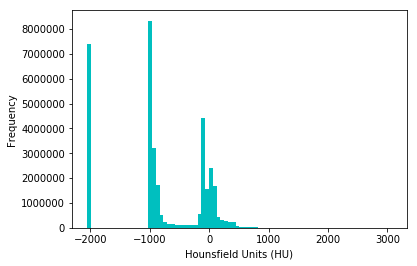

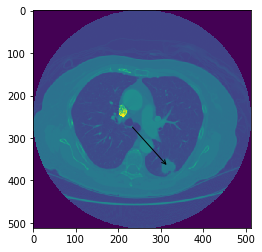

In [21]:
#Let's look at one of the patients
# pat = "LIDC/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-26851/3000972-22902"
# first_patient = load_scan(pat)
first_patient = load_scan(patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

import scipy
# Show some slice in the middle
#data=scipy.ndimage.interpolation.zoom(first_patient_pixels[41],[200,200])
plt.figure()
plt.imshow(first_patient_pixels[42])
plt.annotate('', xy=(317, 367), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
#plt.savefig("images/test.png",dpi=300)
plt.show()


In [19]:
def processimage(img):
    #function sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    #plt.imshow(labels)
    #plt.show()
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    return mask*img

def nodule_coordinates(nodulelocations,meta):
    slices=nodulelocations["slice no."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    xlocs=nodulelocations["x loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    ylocs=nodulelocations["y loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    nodulecoord=[]
    for i in range(len(slices)):
        nodulecoord.append([slices.values[i]-1,xlocs.values[i]-1,ylocs.values[i]-1])
    return nodulecoord

In [50]:
#Generate and save nodule images for all samples
'''
for i in range(15,len(patients)):
    print(i)
    first_patient = load_scan(patients[i])
    first_patient_pixels = get_pixels_hu(first_patient)
    nodcord=nodule_coordinates(nodulelocations,meta.loc[i])
    for j in range(len(nodcord)):
        #plt.imsave("images/"+meta['Patient Id'].loc[i]+"slice"+str(slice)+".png",first_patient_pixels[slice])
        plt.figure()
        plt.imshow(first_patient_pixels[nodcord[j][0]])
        plt.annotate('', xy=(nodcord[j][1], nodcord[j][2]), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
        plt.savefig("images/"+meta['Patient Id'].loc[i]+"slice"+str(nodcord[j])+".png",dpi=300)
        plt.close()
'''

'\nfor i in range(15,len(patients)):\n    print(i)\n    first_patient = load_scan(patients[i])\n    first_patient_pixels = get_pixels_hu(first_patient)\n    nodcord=nodule_coordinates(nodulelocations,meta.loc[i])\n    for j in range(len(nodcord)):\n        #plt.imsave("images/"+meta[\'Patient Id\'].loc[i]+"slice"+str(slice)+".png",first_patient_pixels[slice])\n        plt.figure()\n        plt.imshow(first_patient_pixels[nodcord[j][0]])\n        plt.annotate(\'\', xy=(nodcord[j][1], nodcord[j][2]), xycoords=\'data\',\n             xytext=(0.5, 0.5), textcoords=\'figure fraction\',\n             arrowprops=dict(arrowstyle="->"))\n        plt.savefig("images/"+meta[\'Patient Id\'].loc[i]+"slice"+str(nodcord[j])+".png",dpi=300)\n        plt.close()\n'

In [20]:
noduleimages=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.float32)
nodulemasks=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
nodulemaskscircle=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
index=0
totaltime=50000
start_time=time.time()
elapsed_time=0
nodulemeanhu=[]
nonnodulemeanhu=[]
thresh=-500
for i in range(len(patients)):
    print("Processing patient#",i,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    if len(coord)>0:
        patient=load_scan(patients[i])
        patient_pix=get_pixels_hu(patient)
        radius=nodulelocations["eq. diam."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][i][-4:])]]
        nodulemask=np.ndarray([len(coord),512,512],dtype=np.bool)
        for j,cord in enumerate(coord):
            segmented_mask_fill=segment_lung_mask(patient_pix,True,False)
            if radius.iloc[j]>5:
                #slice nodulecenter-1
                noduleimages[index]=processimage(patient_pix[cord[0]-1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])-1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                rr,cc=circle(int(cord[2]),int(cord[1]),int(radius.iloc[j]))
                imgcircle = np.zeros((512, 512), dtype=np.int16)
                imgcircle[rr,cc]=1
                nodulepixcircle=imgcircle*patient_pix[cord[0]-1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                
                nodulepix=nodulemasks[index]*patient_pix[cord[0]-1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                index+=1
                
                #slice nodulecenter
                noduleimages[index]=processimage(patient_pix[cord[0]])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]]
                nodulepix[nodulepix<thresh]=0
                nodulepixcircle=imgcircle*patient_pix[cord[0]]
                nodulepixcircle[nodulepixcircle<thresh]=0
                
                #get mean nodule HU value

                #get mean non-nodule HU value
                nonnodule=(nodulemasks[index].astype(np.int16)-1)*-1*segmented_mask_fill[cord[0]]*patient_pix[cord[0]]
                nonnodule[nonnodule<thresh]=0
                nonnodulemeanhu.append(np.mean(nonnodule[nonnodule!=0]))
                plt.figure()
                #plt.hist(nodulepix[nodulepix!=0].flatten(),bins=80, alpha=0.5, color='blue')
                plt.hist(nonnodule[nonnodule!=0].flatten(),bins=80, alpha=0.5, color='orange')
                plt.hist(nodulepixcircle[nodulepix!=0].flatten(),bins=80,alpha=0.5, color='green')
                plt.savefig("histplots/"+meta['Patient Id'].loc[i]+"slice"+str(cord)+".png",dpi=300)
                plt.close()
                nodulemeanhu.append(np.mean(nodulepix[nodulepix!=0]))
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
                
                #slice nodulecenter+1
                noduleimages[index]=processimage(patient_pix[cord[0]+1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])+1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]+1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle=imgcircle*patient_pix[cord[0]+1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(i+1)*len(patients)
np.save(datafolder+'/noduleimages.npy',noduleimages)
np.save(datafolder+'/nodulemasks.npy',nodulemasks)
np.save(datafolder+'/nodulemaskscircle.npy',nodulemaskscircle)

Processing patient# 0 ETA: 13.88888888888889 hrs
Processing patient# 1 ETA: 0.6989903891086579 hrs


AttributeError: 'FileDataset' object has no attribute 'ImagePositionPatient'

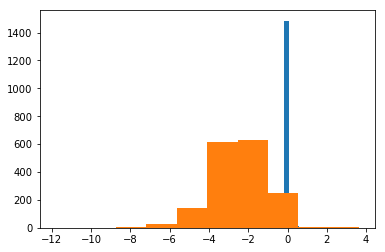

In [70]:
#Exploratory analysis
plt.hist(nodulemeanhu, bins=20)
plt.hist(nonnodulemeanhu)
plt.show()

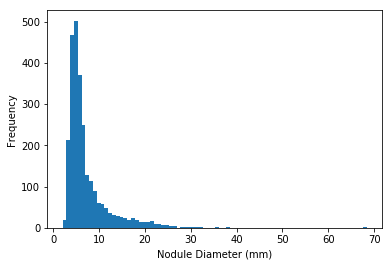

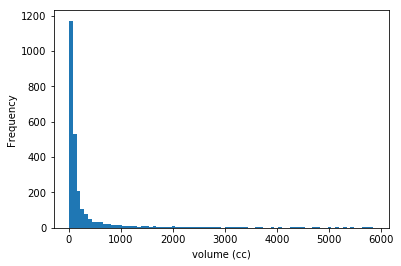

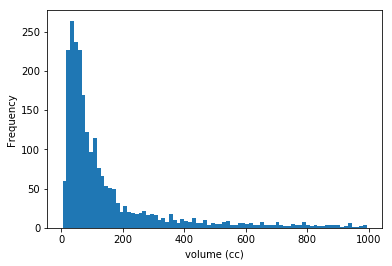

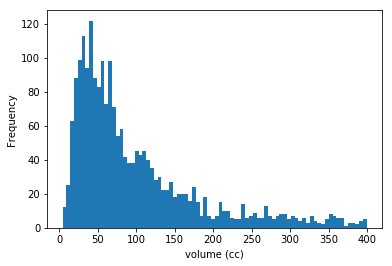

In [18]:
plt.hist(nodulelocations['eq. diam.'], bins=80)
plt.xlabel("Nodule Diameter (mm)")
plt.ylabel("Frequency")
plt.show()

plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<6000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<1000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<400], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()

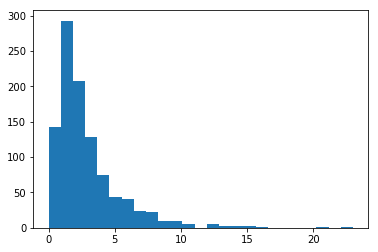

In [25]:
nodcount=[]
for i in range(len(patients)):
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    nodcount.append(len(coord))
    
plt.hist(nodcount, bins=25)
plt.xlabel("Number of Nodules per Patient")
plt.show()